## Reliability application

This is an application of fatigue crack growth probabilistic analysis of a finite width rectangular plate with an edge crack subject to constant amplitude in [1]. 

The number of cycles to failure $N_f$ is given as
$$
N_{f} = \frac{ a_{f}^{1-m/2} - a_{i}^{1-m/2} }{ c (1.1215 \Delta \sigma)^{m} \pi^{m/2} (1-m/2) }
$$

where $m = 3.32$, $c$ is the Paris constant, $\Delta \sigma$ is the load, $a_i$ is the initial crack size, $a_f$ is the final crack size and is expressed as

$$
a_{f} = \frac{1}{\pi} \left( \frac{ K_{IC} }{ 1.1215 \Delta \sigma } \right)^{2}
$$

where $K_{IC}$ is the fracture toughness.


The random variables follow certain distributions given in the following table.

| Random Variable                              | Distribution |   Mean                 |  Standard Deviation    |
|----------------------------------------------|--------------|------------------------|------------------------|
| Load (ksi), $\Delta \sigma$                  |   Lognormal  |  100                   |   10                   |
| Initial Crack Size (in), $a_i$               |   Lognormal  |  0.01                  |   0.005                |
| Paris constant, $c$                          |   Lognormal  |  1.2e-10               |   1.2e-11              |
| Fracture Toughness $ksi/\sqrt{in}$, $K_{IC}$ |   Normal     |  60                    |   6                    |



Reference: 

[1] Choi, S.K., Canfield, R.A. and Grandhi, R.V., 2007. Reliability-Based Structural Optimization (pp. 153-202). Springer London.

In [1]:
# Import auxiliary libraries for demonstration

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams[ "figure.figsize" ] = [ 5, 4 ]

plt.rcParams[ "figure.dpi" ] = 80
plt.rcParams[ "font.family" ] = "Times New Roman"
plt.rcParams[ "font.size" ] = '14'

In [2]:
# Set random seed for repeatable results
from ffpack.config import globalConfig

globalConfig.setSeed( 2023 )

### Parameter distributions

In [3]:
import math
from scipy import stats

m = 3.32

meanStd = [ [ 100, 10 ], [ 0.01, 0.005 ], [ 1.2e-10, 0.12e-10 ], [ 60, 6 ] ]

We need to convert the mean and standard derivation for the lognorm distribution.

A random variable $X$ follows lognormal distribution, and random variable $Y = lnX$ follows a normal distribution.

The PDF of $Y$ is give by 

$$
f_{Y}(y) = \frac{1}{\sqrt{2 \pi} \sigma_{Y}} \exp \left[ -\frac{1}{2} \left( \frac{y - \mu_{Y}}{\sigma_{Y}} \right)^{2} \right], -\infty < y < \infty
$$

The equation can be rewritten in terms of $X$ as

$$
f_{X}(x) = \frac{1}{\sqrt{2 \pi} x\sigma_{Y}} \exp \left[ -\frac{1}{2} \left( \frac{lnx - \mu_{Y}}{\sigma_{Y}} \right)^{2} \right], 0 \leq x < \infty
$$

where
$$
\sigma_{Y}^{2} = \ln\left[ \left( \frac{\sigma_{X}}{\mu_{X}} \right) ^{2} + 1 \right]
$$

$$
\mu_{Y} = \ln\mu_{X} - \frac{1}{2}\sigma_{Y}^{2}
$$


In [4]:
from numpy import log

def convertLognormal(mean, std):
    sigma2 = log( 1 + std**2 / mean**2 )
    mu = log( mean ) - sigma2 / 2
    return ( mu, sigma2 ** 0.5 )

100.00000000000001
10.000000000000005


Text(0.5, 1.0, 'PDF of load')

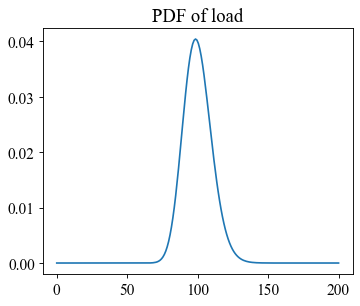

In [5]:
mu, std = convertLognormal(meanStd[0][0], meanStd[0][1])

X1 = stats.lognorm( s=std, scale=np.exp(mu) )
print(X1.mean())
print(X1.var() ** 0.5)

xxx = np.linspace(0, 200, 200)

fig, ax = plt.subplots()

ax.plot(xxx, X1.pdf(xxx))
ax.set_title( "PDF of load" )

0.010000000000000002
0.005


Text(0.5, 1.0, 'PDF of initial crack')

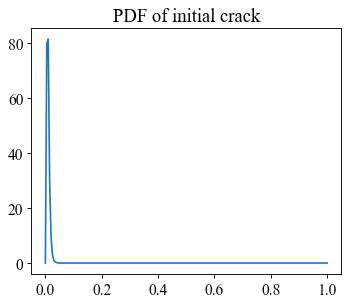

In [6]:
mu, std = convertLognormal(meanStd[1][0], meanStd[1][1])
X2 = stats.lognorm( s=std, scale=np.exp(mu) )
print(X2.mean())
print(X2.var() ** 0.5)

xxx = np.linspace(0, 1, 200)

fig, ax = plt.subplots()

ax.plot(xxx, X2.pdf(xxx))
ax.set_title( "PDF of initial crack" )

1.2000000000000013e-10
1.200000000000002e-11


Text(0.5, 1.0, 'PDF of Paris constant')

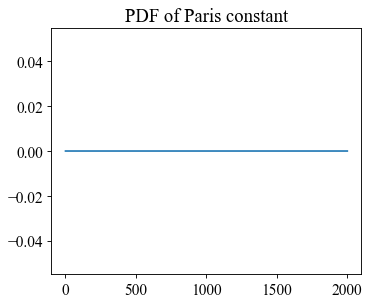

In [7]:
mu, std = convertLognormal(meanStd[2][0], meanStd[2][1])
X3 = stats.lognorm( s=std, scale=np.exp(mu) )
print(X3.mean())
print(X3.var() ** 0.5)

xxx = np.linspace(0, 2000, 2000)

fig, ax = plt.subplots()
ax.plot(xxx, X3.pdf(xxx))
ax.set_title( "PDF of Paris constant" )

Text(0.5, 1.0, 'PDF of fracture toughness')

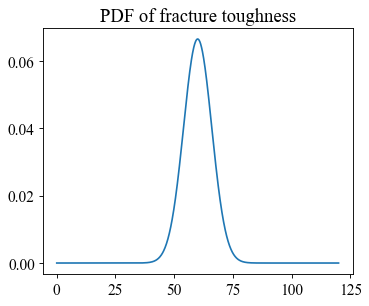

In [8]:
X4 = stats.norm( loc=meanStd[3][0], scale=meanStd[3][1] )

xxx = np.linspace(0, 120, 1200)

fig, ax = plt.subplots()
ax.plot(xxx, X4.pdf(xxx))
ax.set_title( "PDF of fracture toughness" )

### Limit state function

In [9]:
# Define the dimension for the FORM problem
dim = 4

# Define the limit state function (LSF) g
def g( X ):
    numerator = ( ( X[3] / 1.1215 / X[0] ) ** 2 / math.pi ) ** ( 1 - m / 2 ) - X[1] ** ( 1 - m / 2 )
    denominator = X[2] * ( 1.1215 * X[0] ) ** m * math.pi ** ( m / 2 ) * ( 1 - m / 2 )
    return numerator / denominator - 3000

# use internal automatic differentiation algorithm
dg = None

### Marginal distribution

In [10]:
# Marginal distributions and correlation Matrix of the random variables
distObjs = [ X1, X2, X3, X4 ]  
corrMat = np.eye( dim )

In [11]:
# define an array to record the reliability index and failure probability
results = []

### FORM

In [12]:
# FORM: Constrained optimization FORM

from ffpack.rrm import coptFORM

beta, pf, uCoord, xCoord = coptFORM( dim, g, distObjs, corrMat )
results.append( [ beta, pf ] )

In [13]:
print( "Reliability index: " )
print( beta )
print()
print( "Failure probability: " )
print( pf )
print()
print( "Design point coordinate in U space: " )
print( uCoord )
print()
print( "Design point coordinate in X space: " )
print( xCoord )

Reliability index: 
1.0037934895478329

Failure probability: 
0.15773908156041105

Design point coordinate in U space: 
[0.6472382726814411, 0.7428977098133317, 0.16674351823826586, -0.09478174884750643]

Design point coordinate in X space: 
[106.13988658677613, 0.012704342671365916, 1.2140711290863364e-10, 59.431309506914964]


### SORM

In [14]:
# SORM: Breitung SORM

from ffpack.rrm import breitungSORM

beta, pf, uCoord, xCoord = breitungSORM( dim, g, dg, distObjs, corrMat )
results.append( [ beta, pf ] )

In [15]:
print( "Reliability index: " )
print( beta )
print()
print( "Failure probability: " )
print( pf )
print()
print( "Design point coordinate in U space: " )
print( uCoord )
print()
print( "Design point coordinate in X space: " )
print( xCoord )

Reliability index: 
1.0037934895478329

Failure probability: 
0.1460989862149804

Design point coordinate in U space: 
[0.6472382726814411, 0.7428977098133317, 0.16674351823826586, -0.09478174884750643]

Design point coordinate in X space: 
[106.13988658677613, 0.012704342671365916, 1.2140711290863364e-10, 59.431309506914964]


In [16]:
# SORM: Tvedt SORM

from ffpack.rrm import tvedtSORM

beta, pf, uCoord, xCoord = tvedtSORM( dim, g, dg, distObjs, corrMat )
results.append( [ beta, pf ] )

In [17]:
print( "Reliability index: " )
print( beta )
print()
print( "Failure probability: " )
print( pf )
print()
print( "Design point coordinate in U space: " )
print( uCoord )
print()
print( "Design point coordinate in X space: " )
print( xCoord )

Reliability index: 
1.0037934895478329

Failure probability: 
0.13184401228952822

Design point coordinate in U space: 
[0.6472382726814411, 0.7428977098133317, 0.16674351823826586, -0.09478174884750643]

Design point coordinate in X space: 
[106.13988658677613, 0.012704342671365916, 1.2140711290863364e-10, 59.431309506914964]


In [18]:
# SORM: Hohenbichler and Rackwitz SORM

from ffpack.rrm import hrackSORM

beta, pf, uCoord, xCoord = hrackSORM( dim, g, dg, distObjs, corrMat )
results.append( [ beta, pf ] )

In [19]:
print( "Reliability index: " )
print( beta )
print()
print( "Failure probability: " )
print( pf )
print()
print( "Design point coordinate in U space: " )
print( uCoord )
print()
print( "Design point coordinate in X space: " )
print( xCoord )

Reliability index: 
1.0037934895478329

Failure probability: 
0.1540947049684117

Design point coordinate in U space: 
[0.6472382726814411, 0.7428977098133317, 0.16674351823826586, -0.09478174884750643]

Design point coordinate in X space: 
[106.13988658677613, 0.012704342671365916, 1.2140711290863364e-10, 59.431309506914964]


### Result comparison

In [20]:
# results in reference [1]
ref = [ 0.15774, 0.14473, 0.13987, np.nan ]

In [21]:
# combine the two arrays using np.concatenate
combined_array = np.concatenate((results, np.array(ref).reshape(-1, 1)), axis=1)

# format the array elements as strings
data_str = [['{:.4f}'.format(item) for item in row ] for row in combined_array]

# define the first column
extra = [ 'FORM', 'SORM - Breitung', 'SORM - Tvedt', 'SORM - Hrack']

# define the column headers
headers = [ 'Method', 'Reliability index', 'Pf - Ours', 'Pf - Ref']

# Print the array as a formatted table
print('{:<20} {:<20} {:<15} {:<15}'.format(*headers))  # Print the header row

for i in range( len( data_str ) ):
    print('{:<20} {:<20} {:<15} {:<15}'
          .format( np.array(extra)[i] , data_str[i][0], data_str[i][1], data_str[i][2] ) )

Method               Reliability index    Pf - Ours       Pf - Ref       
FORM                 1.0038               0.1577          0.1577         
SORM - Breitung      1.0038               0.1461          0.1447         
SORM - Tvedt         1.0038               0.1318          0.1399         
SORM - Hrack         1.0038               0.1541          nan            


The failure probabilities with different methods are very close to the results in reference [1]. The reliability indices given by different methods are consistent. 